# Installs and imports

In [ ]:
#%pip install pystac_client
#%pip install requests
#%pip install aiohttp
#%pip install h5netcdf
#%pip install scikit-learn

In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import numpy as np
import requests
from IPython.display import Image, display
import os 
import pathlib

# Getting and Opening the data

In [2]:
# Opens catalog where products are stored
catalog_url = 'https://catalog.maap.eo.esa.int/catalogue/'
catalog = Client.open(catalog_url)

In [3]:
# Defines L1 or L2 products
EC_COLLECTION = ['EarthCAREL2Validated_MAAP']

Now we search if there are  products at the area, orbit and time we want.

- collections = L1 or L2 collections (the cell above)
- filter: filter by product name and orbit. Match them using logic operators. Eg. product name __and__ orbit. More than one orbit use orbit1 __or__ orbit 2.

      - productType = 'name of the product'
      - frame = 'orbit name'. Find a simple visualization at [https://www.eorc.jaxa.jp/EARTHCARE/Quicklook/]
- bbox = \[lon min, lat min, lon max, lat max] PS: lonngitudes are in -180, 180 format.
- method = 'GET' needed to get the information
- max_items: maximum number of items we want to find. The largets the number, the more it will take to find them

In [10]:
#West Pacific
searchwp = catalog.search(
    collections=EC_COLLECTION, 
    filter="productType = 'ATL_ALD_2A' and (frame = 'A' or frame='E') ", # Filter by product type
    bbox = [100, -15,160, 30],
    #datetime = ['2025-06-26T00:00:00Z', None], 
    method = 'GET', # This is necessary 
    max_items=1000  # Adjust as needed, given the large aoutn of products it is recommended to set a limit
)

items = list(searchwp.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{searchwp.matched()} items found that matched the query.")

Accessing 712 items (limited by max_items).
712 items found that matched the query.


In [4]:
#East Pacific
search = catalog.search(
    collections=EC_COLLECTION, 
    filter="productType = 'ATL_ALD_2A' and (frame = 'A' or frame='E') ", # Filter by product type
    bbox = [-160, -10,-100, 20],
    #datetime = ['2025-06-26T00:00:00Z', None], 
    method = 'GET', # This is necessary 
    #max_items=5  # Adjust as needed, given the large aoutn of products it is recommended to set a limit
)

items = list(search.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{search.matched()} items found that matched the query.")

Accessing 860 items (limited by max_items).
860 items found that matched the query.


In [58]:
#Poles

search = catalog.search(
    collections=EC_COLLECTION, 
    filter="productType = 'ATL_ALD_2A' and (frame = 'G') ", # Filter by product type
    #bbox = [-160, -10,-100, 20],
    #datetime = ['2025-06-26T00:00:00Z', None], 
    method = 'GET', # This is necessary 
    #max_items=5  # Adjust as needed, given the large aoutn of products it is recommended to set a limit
)

items = list(search.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{search.matched()} items found that matched the query.")

In [5]:
# Retrieve links to data and quicklooks 

data = search.item_collection_as_dict()

df = pd.json_normalize(data, record_path=['features'])[
    [
        "id",
        "properties.product:type",                
        "properties.updated",                     
        "assets.product.href",
        "assets.thumbnail.href",
        "assets.quicklook.href",
        "assets.enclosure_1.href",
        "assets.enclosure_2.href",
    ]
]

# Renaming the assets for 
df.rename(columns={
    'properties.product:type': 'product_type',
    'properties.updated': 'last_modified',
    'assets.product.href': 'Zipped Product',
    'assets.thumbnail.href': 'thumbnail_url',
    'assets.quicklook.href': 'quicklook_url',
    'assets.enclosure_1.href': 'h5_url',
    'assets.enclosure_2.href': 'HDR_url',
}, inplace=True)

df.sort_values(by='id', ascending=True, inplace=True)

In [1]:
#Check that len of df is the same as len number of items found
len(df)

NameError: name 'df' is not defined

In [7]:
df.head()

,id,product_type,last_modified,Zipped Product,thumbnail_url,quicklook_url,h5_url,HDR_url
468,ECA_EXAE_ATL_ALD_2A_20250311T122613Z_20250311T...,ATL_ALD_2A,2025-09-14T00:47:06Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
20,ECA_EXAE_ATL_ALD_2A_20250311T205508Z_20250311T...,ATL_ALD_2A,2025-09-14T00:47:19Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
692,ECA_EXAE_ATL_ALD_2A_20250311T222741Z_20250312T...,ATL_ALD_2A,2025-09-14T00:47:22Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
693,ECA_EXAE_ATL_ALD_2A_20250312T000014Z_20250312T...,ATL_ALD_2A,2025-09-14T00:47:26Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
41,ECA_EXAE_ATL_ALD_2A_20250312T082920Z_20250312T...,ATL_ALD_2A,2025-09-14T00:47:41Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...


In [8]:
# Get the urls where the files are stored. This is the h5_url column of the dataframe
ds_url = df["h5_url"]
print(ds_url)

468    https://catalog.maap.eo.esa.int/data/earthcare...
20     https://catalog.maap.eo.esa.int/data/earthcare...
692    https://catalog.maap.eo.esa.int/data/earthcare...
693    https://catalog.maap.eo.esa.int/data/earthcare...
41     https://catalog.maap.eo.esa.int/data/earthcare...
                             ...                        
857    https://catalog.maap.eo.esa.int/data/earthcare...
203    https://catalog.maap.eo.esa.int/data/earthcare...
427    https://catalog.maap.eo.esa.int/data/earthcare...
859    https://catalog.maap.eo.esa.int/data/earthcare...
428    https://catalog.maap.eo.esa.int/data/earthcare...
Name: h5_url, Length: 860, dtype: object


In [14]:
ds_url.to_list()[:5]

['https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/ATL_ALD_2A/AE/2025/03/12/ECA_EXAE_ATL_ALD_2A_20250312T043753Z_20250312T075001Z_04469E/ECA_EXAE_ATL_ALD_2A_20250312T043753Z_20250312T075001Z_04469E/ECA_EXAE_ATL_ALD_2A_20250312T043753Z_20250312T075001Z_04469E.h5',
 'https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/ATL_ALD_2A/AE/2025/03/12/ECA_EXAE_ATL_ALD_2A_20250312T061027Z_20250312T074812Z_04470E/ECA_EXAE_ATL_ALD_2A_20250312T061027Z_20250312T074812Z_04470E/ECA_EXAE_ATL_ALD_2A_20250312T061027Z_20250312T074812Z_04470E.h5',
 'https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/ATL_ALD_2A/AE/2025/03/12/ECA_EXAE_ATL_ALD_2A_20250312T161206Z_20250312T170433Z_04477A/ECA_EXAE_ATL_ALD_2A_20250312T161206Z_20250312T170433Z_04477A/ECA_EXAE_ATL_ALD_2A_20250312T161206Z_20250312T170433Z_04477A.h5',
 'https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/ATL_ALD_2A/AE/2025/03/12/ECA_EXAE_ATL_ALD_2A_20250312T174439Z_20250312T214348Z_04478A/ECA_EXA

In [3]:
# Use your ESA token 
_TOKEN = ""

In [10]:
if pathlib.Path("token.txt").exists():
  with open("token.txt","rt") as f:
    token = f.read().strip().replace("\n","")
else:
  token=_TOKEN

In [11]:
fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})

# Creating datasets

We will create an xarray dataset retrieved from ATLID 2A, using only yhe aerosol optical depoth property at 355nm. 

In [12]:
%%time

dslist = []

for url in ds_url.to_list():
    #print(url)
    f = fs.open(url, "rb")
    ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData")
    aot = ds.aerosol_optical_thickness_355nm
    aotnew = aot.assign_coords({"along_track":ds.time, "lat": ds.latitude,"lon": ds.longitude, })
    aotnew = aotnew.rename({"along_track": "time"})                           
    ds.close()
    dslist.append(aotnew)
#xr.concat()

CPU times: user 3min 8s, sys: 2.72 s, total: 3min 11s
Wall time: 10min 10s


In [13]:
# Check that is the same len as the number if items found
len(dslist)

860

In [14]:
# CONCATENATE ALL ITEMS FOUND IN ONE SINGLE XARRAY DATASET
aot_all = xr.concat(dslist, dim="time")

aot_all

Resample to 1 second of temporal resolution (taking the mean value)

In [15]:
%%time
resampled_aot = aot_all.resample(time='1s').mean().dropna(dim='time', how='all')

CPU times: user 2min 19s, sys: 3.32 s, total: 2min 22s
Wall time: 2min 22s


In [16]:
# What's the max value? 
np.max(aot_all.values[~np.isnan(aot_all.values)])

np.float32(9.339119e+34)

In [18]:
resampled_aot

<xarray.DataArray 'aerosol_optical_thickness_355nm' (time: 64557)> Size: 258kB
array([3.1814131e+34, 1.9542373e+00, 4.4990907e+00, ..., 2.7859421e+00,
       2.9992530e+00, 6.9233718e+00], shape=(64557,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 516kB 2025-03-11T12:26:11 ... 2025-09-22T2...
Attributes:
    long_name:  Column aerosol optical thickness at 355 nm
    notes:      -
    units:      1

In [19]:
# Get rid of 0s
resampled_aot_no0 = resampled_aot.where(resampled_aot != 0.)
resampled_aot_no0

<xarray.DataArray 'aerosol_optical_thickness_355nm' (time: 64557)> Size: 258kB
array([3.1814131e+34, 1.9542373e+00, 4.4990907e+00, ..., 2.7859421e+00,
       2.9992530e+00, 6.9233718e+00], shape=(64557,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 516kB 2025-03-11T12:26:11 ... 2025-09-22T2...
Attributes:
    long_name:  Column aerosol optical thickness at 355 nm
    notes:      -
    units:      1

In [41]:
np.max(np.log(resampled_aot.values)), np.min(np.log(resampled_aot.values))

/tmp/ipykernel_80/3467916268.py:1: RuntimeWarning: divide by zero encountered in log
  np.max(np.log(resampled_aot.values)), np.min(np.log(resampled_aot.values))
/tmp/ipykernel_80/3467916268.py:1: RuntimeWarning: invalid value encountered in log
  np.max(np.log(resampled_aot.values)), np.min(np.log(resampled_aot.values))


(np.float32(nan), np.float32(nan))

In [40]:
resampled_aot.values[resampled_aot.values==-9.4153433e+27]

array([-9.4153433e+27], dtype=float32)

In [21]:
# Save the file in netCDF format
resampled_aot.to_netcdf("aot_resampled_ep.nc")

# Some kmeans play

In [16]:
with fs.open(ds_url.to_list()[5], "rb") as f:
    ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData").copy()
ds

<xarray.Dataset> Size: 7MB
Dimensions:                                              (along_track: 5063,
                                                          max_layers: 20,
                                                          aerosol_consistency_dimension: 2,
                                                          n_classes: 7)
Dimensions without coordinates: along_track, max_layers,
                                aerosol_consistency_dimension, n_classes
Data variables: (12/31)
    time                                                 (along_track) datetime64[ns] 41kB ...
    latitude                                             (along_track) float64 41kB ...
    longitude                                            (along_track) float64 41kB ...
    geoid_offset                                         (along_track) float32 20kB ...
    aerosol_layer_number                                 (along_track) float32 20kB ...
    aerosol_layer_base                                   (along_track, max_layers) float32 405kB ...
    ...                                                   ...
    aerosol_optical_thickness_355nm_error                (along_track) float32 20kB ...
    aerosol_detection_consistency                        (along_track, aerosol_consistency_dimension) float32 41kB ...
    aerosol_columnar_classification_probabilities        (along_track, n_classes) float32 142kB ...
    quality_status                                       (along_track) float32 20kB ...
    tropopause_height_wmo                                (along_track) float32 20kB ...
    tropopause_height_calipso                            (along_track) float32 20kB ...

In [45]:
#fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
f = fs.open(ds_url.to_list()[5], "rb")
ds5 = xr.open_dataset(f, engine="h5netcdf", group="ScienceData")
ds5

<xarray.Dataset> Size: 7MB
Dimensions:                                              (along_track: 5063,
                                                          max_layers: 20,
                                                          aerosol_consistency_dimension: 2,
                                                          n_classes: 7)
Dimensions without coordinates: along_track, max_layers,
                                aerosol_consistency_dimension, n_classes
Data variables: (12/31)
    time                                                 (along_track) datetime64[ns] 41kB ...
    latitude                                             (along_track) float64 41kB ...
    longitude                                            (along_track) float64 41kB ...
    geoid_offset                                         (along_track) float32 20kB ...
    aerosol_layer_number                                 (along_track) float32 20kB ...
    aerosol_layer_base                                   (along_track, max_layers) float32 405kB ...
    ...                                                   ...
    aerosol_optical_thickness_355nm_error                (along_track) float32 20kB ...
    aerosol_detection_consistency                        (along_track, aerosol_consistency_dimension) float32 41kB ...
    aerosol_columnar_classification_probabilities        (along_track, n_classes) float32 142kB ...
    quality_status                                       (along_track) float32 20kB ...
    tropopause_height_wmo                                (along_track) float32 20kB ...
    tropopause_height_calipso                            (along_track) float32 20kB ...

In [50]:
ds5.aerosol_optical_thickness_355nm.values[ds5.aerosol_optical_thickness_355nm.values==0]

array([], dtype=float32)

In [53]:
np.max(ds5.aerosol_optical_thickness_355nm.values[~np.isnan(ds5.aerosol_optical_thickness_355nm.values)])

np.float32(40.359127)

In [42]:
aot = ds.aerosol_optical_thickness_355nm
aot = aot.assign_coords( {"along_track":ds.time, "lat": ds.latitude,"lon": ds.longitude, })
aot #.aerosol_columnar_classification_probabilities.plot(x="along_track")

<xarray.DataArray 'aerosol_optical_thickness_355nm' (along_track: 5063)> Size: 20kB
array([nan, nan, nan, ..., nan, nan, nan], shape=(5063,), dtype=float32)
Coordinates:
  * along_track  (along_track) datetime64[ns] 41kB 2025-03-13T06:51:07.363696...
    lat          (along_track) float64 41kB 23.35 23.34 23.33 ... -23.37 -23.38
    lon          (along_track) float64 41kB 109.7 109.7 109.7 ... 100.7 100.7
Attributes:
    long_name:  Column aerosol optical thickness at 355 nm
    notes:      -
    units:      1

Kmeans

In [87]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
featureNames = ["AOT","LIWP"]

In [ ]:
kmeans = KMeans(n_clusters=k, n_init=100)
        #self.labels = kmeans.fit_predict(X_std)
        #self.centers = kmeans.cluster_centers_
        #self.stats = scaler

Initialization complete
Iteration 0, inertia 2065.67.
Iteration 1, inertia 681.3705999999999.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 286.84000000000015.
Iteration 1, inertia 152.9324126095459.
Iteration 2, inertia 152.34795176035792.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 202.09000000000006.
Iteration 1, inertia 79.04508205350014.
Iteration 2, inertia 78.85566582597731.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 126.22000000000004.
Iteration 1, inertia 73.2965200896648.
Iteration 2, inertia 71.74022427298274.
Iteration 3, inertia 71.51237138153284.
Iteration 4, inertia 71.4494710207825.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 84.25.
Iteration 1, inertia 58.15730240528279.
Iteration 2, inertia 50.996343423158436.
Iteration 3, inertia 49.885178769841275.
Iteration 4, inertia 49.8222784090

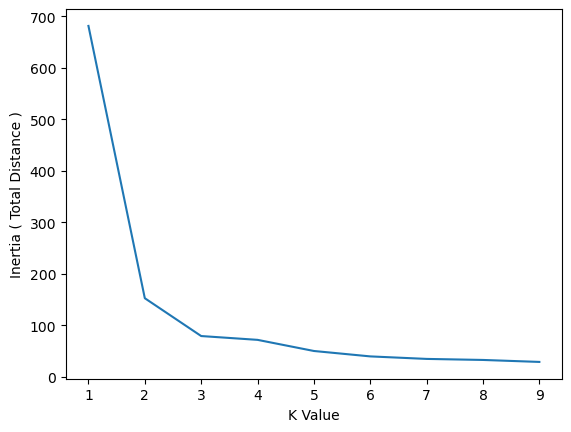

In [58]:
#IMPORT LIBRARIES
import numpy as np
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
#LOAD IRIS DATASET
iris=datasets.load_iris()
x=iris.data
target=iris.target

#Create a function that calculates Inertia for n times
#We will sweep through 1 to n to find the optimal cluster number

def cluster_variance(n):
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
        model=KMeans(n_clusters=i,random_state=82,verbose=2).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n
    
variances,K,n=cluster_variance(9)
plt.plot(K,variances)
plt.ylabel("Inertia ( Total Distance )")
plt.xlabel("K Value")
plt.xticks([i for i in range(1,n+1)])
plt.show()